# Introduction

version 3: moved to O&G\OH directory structure, so had to change directory pointers.

This notebook contains the code to transform the Excel files available through ODNR (<http://oilandgas.ohiodnr.gov/production>) to a dataset of the format needed for planned analysis.
Currently, ODNR produces quarterly files with production numbers of oil (bbl), gas (mcf) and brine (bbl). Data for 2011 and 2012 (the first years of the data) have only annual numbers.

This notebook is version 2 and will create separate sets of wells that first start producing in the same time period (usually quarter, except 2011-12).

Data produced using the earlier version ('ODNR Production data.ipynb') were used by Ted Auch in his article for the FracTracker web site <https://www.fractracker.org/2019/01/diminishing-returns-in-ohio/> . This version uses the same data, but formats it in a way for wider uses.

 

# Imports and directory definitions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os

   
# set datadir to the directory that holds the files on YOUR computer
datadir = './sources/'
outdir = './out/'
# this is the directory that contains the odnr excel files.  Note that the must be remaned to the format described 
#   in the next section
indir = datadir+'odnr_production_files/'

### ODNR cumulative permit files.
utica = datadir+'Utica_052519.xlsx'
marcellus = datadir+'Marcellus_052519.xlsx'


# for viewing of data at interim points 
tempfn = outdir+'temp.csv'
tempexcel = outdir+'temp.xlsx'

# output name suffix
outsuff = '_production_by_start_period.xlsx'

## A function we will need to save data in separate worksheets

In [2]:
# used to save the final data into several worksheets of the same excel file.
def save_xls(dict_df, xlsx_path):
    writer = pd.ExcelWriter(xlsx_path,engine='xlsxwriter')
    for key in dict_df:
        dict_df[key].to_excel(writer,sheet_name= f'{key}')
    writer.save()    



# Get metadata from ODNR permit sheets

In [3]:
####  Read in the ODNR excel sheets for the meta-data for each well.

uti = pd.read_excel(utica,header=4,dtype={'API #':'category'})
mar = pd.read_excel(marcellus,header=4,dtype={'API #':'category'})
permit = pd.concat([uti,mar])

# rename a few things
permit.columns = ['pdate','county','township','APINumber','Status','Operator',
                  'WellName_Number','SurfLat','SurfLon','EndLat','EndLon']

permit = permit.dropna(subset=['APINumber'])
#print(len(permit))
permit = permit.drop_duplicates(subset=['APINumber'],keep='last') # the permit file has a few duplicates, keep recent
print(f'Total number of unique APINumbers in permit file: {len(permit)}')

# keep only those fields that are of interest in final production sheets
permit = permit.filter(['APINumber','Operator','WellName_Number',
                        'SurfLat','SurfLon','EndLat','EndLon'])
permit.head()


Total number of unique APINumbers in permit file: 3159


,APINumber,Operator,WellName_Number,SurfLat,SurfLon,EndLat,EndLon
1,34005241600100,DEVON ENERGY PRODUCTION CO LP,EICHELBERGER DAVID 1H,40.9466508,-82.4034777,40.9594639,-82.4036401
2,34007245510100,BEUSA ENERGY LLC,MAGYAR 9 1H,41.5204837,-80.6934257,41.5005237,-80.6788228
4,34013206540100,XTO ENERGY INC.,KALDOR 1H,39.9760339,-80.8381875,39.9667858,-80.8196294
5,34013206570100,GULFPORT ENERGY CORPORATION,SHUGERT 1-1H,40.0431192,-81.1231952,40.0574876,-81.1320239
6,34013206580100,GULFPORT ENERGY CORPORATION,SHUGERT 1-12H,40.0326937,-81.1457695,40.0538862,-81.1556195


# Fetch the data; concat

Because the data in the files from ODNR is not exactly consistent, We must name the files by hand and use the name of those files as info for the resulting dataframe.  Specifically, name files downloaded as : 'YEAR_Q.extension'.  Keep the same extension as the downloaded file (xls or xslx).  This program will use the Year and Q info to label the records in the dataframe.

In [4]:
#  The files from 2011 and 2012 are a different format and order so we need different sets of column names.

colnames1 = ['APINumber','Yr','Q','Owner','County','Twp','WellName','WellNum','Oil','Gas','Brine','Days']
colnames2 = ['Yr','Q','Owner','County','APINumber','Twp','WellName-WellNum','Oil','Gas','Brine','Days','FirstDate']

dlst = []
filelist = os.listdir(indir)
for f in filelist:
    d = pd.read_excel(indir+f)
    if f[:4] in ['2011','2012']:
        # Need to create four quarters out of the yearly data.
        d.columns = colnames2
        #d['period'] = pd.to_period(f)
        d['Year'] = f[:4]
        d['Quarter'] = 'X' # for these years, quarterly data is not given.  Flag with a 'X' quarter.
        d['period'] = f[:4]+'QX' # mark these as non-quarter years
    else:
        # The quarterly data...
        d.columns = colnames1
        d['Year'] = f[:4]
        d['Quarter'] = f[5]
        d['period'] = f[:6].replace('_','Q')

    # now convert all oil,gas and brine measures by #/days to adjust for variable 
    #   production days in each reporting period
    d['Gas'] = d.Gas/d.Days
    d['Oil'] = d.Oil/d.Days
    d['Brine'] = d.Brine/d.Days
    d = d.filter(['APINumber','Year','Quarter','Owner','Oil','Gas','Brine','Days','period'])
    
    d.APINumber = d.APINumber.fillna(0).astype('int64').astype(str)
    #print(d.APINumber.describe())
    dlst.append(d)
df_all = pd.concat(dlst,sort=True)
df_all.head(20)

,APINumber,Brine,Days,Gas,Oil,Owner,Quarter,Year,period
0,34067210570100,45.136364,198.0,7694.267677,68.040404,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
1,34019220730100,114.490291,206.0,1565.218447,59.873786,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
2,34019220850000,402.000000,5.0,0.000000,130.800000,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
3,34019220810100,933.000000,11.0,0.000000,74.363636,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
4,34019220740000,45.339623,53.0,2588.528302,40.886792,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
5,34099231350100,106.189873,79.0,0.000000,9.594937,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
6,34133244200100,89.800000,20.0,0.000000,29.150000,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
7,34019220760100,98.934783,92.0,1990.673913,66.260870,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
8,34019220750000,73.223077,130.0,3040.692308,72.646154,CHESAPEAKE APPALACHIA LLC,X,2011,2011QX
0,34019221100000,138.788462,52.0,1083.923077,226.153846,CHESAPEAKE EXPLORATION LLC,X,2012,2012QX


**Note that the data in the df_all dataframe are already recalculated to per/day values.**

# Gas records processing (an illustration)
this is an illustration of what is done to Gas,Oil and Brine all at once below. 

## Pivot for columns as API, rows as time periods
In some reporting quarters, some wells are reported more than once.  For these, we take the sum for a given well as the total production for that period. We then pivot the dataset so that each well is a column.

In [5]:
gas = df_all[['APINumber','period','Gas']]
gasgb = gas.groupby(['period','APINumber'],as_index=False)['Gas'].sum()
Gas_pivot =gasgb.pivot(index='period',columns='APINumber')
Gas_pivot.columns = Gas_pivot.columns.get_level_values(1) # snags the API# as the column name
Gas_pivot.fillna(0,inplace=True) # if a well had no record in a time period, make it '0' instead of NaN.
Gas_pivot.drop('0',axis=1,inplace=True) # drop the column named '0' - it is an artifact.


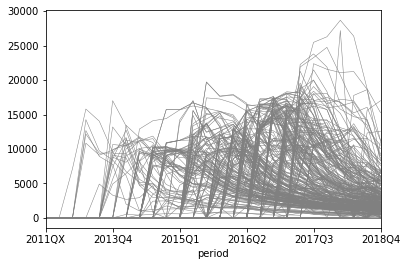

In [6]:
# plot some curves, ignore start time
Gas_pivot.plot(y=Gas_pivot.columns[:300],use_index=True,legend=False,linewidth=0.5,color='gray')

## find the first non-zero data point in the timeseries

In [7]:
id_lst = list(Gas_pivot.index)

def id_first_nonzero(ser):
    # returns the index of the first non-zero component (that is, when well comes on line)
    lst = np.nonzero(ser)
    #print(len(lst),lst)
    if len(lst[0])==0:
        return 'all_zero'
    return id_lst[lst[0][0]] # use the first value in the non-zero list to point into the period index

#### test function -----------
ser = pd.Series([0,0,0,1])
id_first_nonzero(ser)
##### --------------------
strt = pd.DataFrame(Gas_pivot.apply(id_first_nonzero),columns=['start_period']) 
strt.tail()

C:\Users\BMansfield\Anaconda3\envs\datawork\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


,start_period
APINumber,
34167297570100,2015Q4
34167297590000,2016Q2
34167297610000,2016Q2
34167297610100,2018Q1
34169256690100,all_zero


## merge start period with production data

In [8]:
# merge gas data with column that points to first non-zero data
mg = pd.merge(strt,Gas_pivot.T,on='APINumber',how='outer',validate='1:1')
mg.head(10)

,start_period,2011QX,2012QX,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,...,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4
APINumber,,,,,,,,,,,,,,,,,,,,,
34005241600100,all_zero,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34013205830000,2013Q1,0.0,0.0,23.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34013206190000,all_zero,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34013206200000,all_zero,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34013206530000,2014Q1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,513.556962,401.582418,524.186813,...,586.238095,913.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1014.419355,564.042857,384.354430
34013206540100,2013Q4,0.0,0.0,0.000000,0.000000,0.000000,13194.333333,10606.483146,6893.252747,4263.868132,...,1508.913580,622.416667,2293.015152,2010.087912,1539.173913,1191.230769,1165.506494,983.011364,372.858696,449.061728
34013206570100,2013Q2,0.0,0.0,0.000000,12672.535211,8931.022989,7765.738095,2010.207317,1006.500000,1244.790123,...,487.219780,427.089888,379.255556,718.786517,700.163043,498.195652,563.404494,523.043956,485.858696,463.703297
34013206580100,2013Q2,0.0,0.0,0.000000,14263.219178,9740.188235,8405.050633,6165.701493,1066.000000,911.234375,...,2149.450549,1986.791209,1817.322222,1678.560440,1546.195652,1509.836957,1342.622222,1199.109890,1208.608696,1183.967391
34013206600100,2013Q3,0.0,0.0,0.000000,0.000000,4913.434783,3297.088235,2688.513158,2935.406977,4692.297872,...,1178.934783,806.934066,843.855556,737.915493,816.869565,812.164835,615.872340,879.791209,707.706522,699.164835


## make some plots to verify separation by period

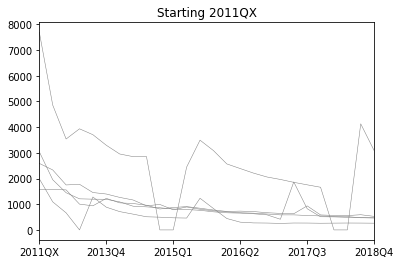

In [9]:
def plotperiod(per='2011QX'):
    tdf = mg[mg.start_period==per]
    #tdf.info()
    tdf= tdf.drop(['start_period'],axis=1)
    #tdf.info()
    #tdf =tdf.set_index('APINumber')
    t = tdf.T
    t.plot(y=t.columns,use_index=True,legend=False,linewidth=0.5,color='gray',title=f'Starting {per}')
plotperiod(per='2011QX')

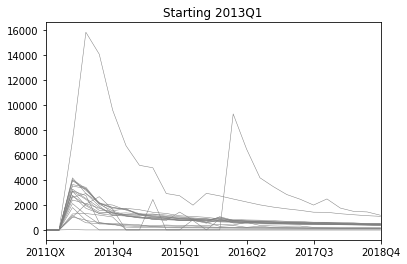

In [10]:
plotperiod(per='2013Q1')

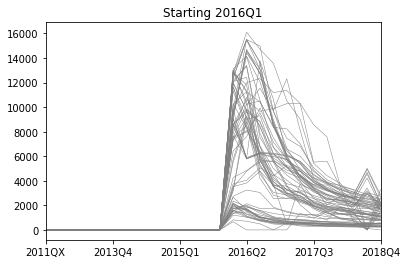

In [11]:
plotperiod(per='2016Q1')

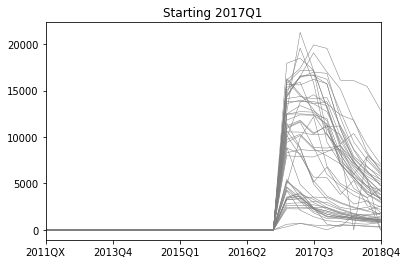

In [12]:
plotperiod(per='2017Q1')

## merge with permit data to get location and ownership of each well

In [13]:
# now merge with some of the well identifiers pulled in from the permit dataset.
mg = pd.merge(permit,mg,on='APINumber',validate='1:1',indicator=True,how='outer')
mg = mg[mg._merge != 'left_only']  # drop the permit rows that don't have corresponding production; keep non-meta rows
mg = mg.drop(['_merge'],axis=1)
print(len(mg))
mg.to_csv(tempfn)

2233


## finally, save in excel file with separate sheets

In [14]:
fsdict = {} # dict to hold set parsed by first_nonzero
fslst = sorted(list(strt.start_period.unique()))
for fs in fslst:
    fsdict[fs] = mg[mg.start_period == fs]
save_xls(fsdict,tempexcel)


# Process Gas, Oil and Brine with function

Now let's do it for real.  Process each of the production types using a function that just passes the name of each...

## Define the functions that will do the processing

In [15]:
# used to find the id of the first
def id_first_nonzero(ser):
    # returns the index of the first non-zero component (that is, when well comes on line)
    lst = np.nonzero(ser)
    #print(len(lst),lst)
    if len(lst[0])==0:
        return 'all_zero'
    return id_lst[lst[0][0]] # use the first value in the non-zero list to point into the period index

def processAll():
    for pn in ['Gas','Oil','Brine']:
        temp = processProduct(pn)

def processProduct(pname='Gas'):
    product = df_all[['APINumber','period',pname]]  # make small dataset with just 3 columns
    productgb = product.groupby(['period','APINumber'],as_index=False)[pname].sum()
    Pivot =productgb.pivot(index='period',columns='APINumber')
    Pivot.columns = Pivot.columns.get_level_values(1) # snags the API# as the column name
    Pivot.fillna(0,inplace=True) # if a well had no record in a time period, make it '0' instead of NaN.
    Pivot.drop('0',axis=1,inplace=True)# drop the column named '0' - it is an artifact.

    id_lst = list(Pivot.index)
    strt = pd.DataFrame(Pivot.apply(id_first_nonzero),columns=['start_period']) 

    # merge production data with column that points to first non-zero data
    mg = pd.merge(strt,Pivot.T,on='APINumber',how='outer',validate='1:1')

    # now merge with some of the well identifiers pulled in from the permit dataset.
    mg = pd.merge(permit,mg,on='APINumber',validate='1:1',indicator=True,how='outer')
    mg = mg[mg._merge != 'left_only']  # drop the permit rows that don't have corresponding production; keep non-meta rows
    mg = mg.drop(['_merge'],axis=1)

    fsdict = {} # dict to hold set parsed by first_nonzero
    fslst = sorted(list(strt.start_period.unique()))
    for fs in fslst:
        fsdict[fs] = mg[mg.start_period == fs]
    save_xls(fsdict,f'{outdir}{pname}{outsuff}')

    return fsdict

## Finally, make all three files

In [16]:
processAll()